In [16]:
import sys
sys.path.append('../')
import numpy as np
import torch

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import Operator
from torchqc.common_matrices import sigmaZ, sigmaY
from torchqc.dynamics import TDSE, lindblad_equation
from torchqc.tensor_product import tensor_product_states, tensor_product_ops, partial_trace

* Start from basis state $\ket{0}$

In [17]:
n = 2
basis_states = QuantumState.basis(n)
state1 = basis_states[0]
state2 = basis_states[1]

initial_state = tensor_product_states(state1, state2)

In [18]:
initial_state.product_dims

[2, 2]

In [19]:
state = state2
state.normalize()

stateA = get_density_matrix((state1 + state2).normalize())
stateB = get_density_matrix((state1 + 2 * state2).normalize())

print("stateA = ", stateA.matrix)
print("stateB", stateB.matrix)
stateAB = tensor_product_ops(stateA, stateB)
print("stateAB = ", stateAB.matrix)

stateA = partial_trace(stateAB, [1])
stateB = partial_trace(stateAB, [0])

print("reduced stateA = ", stateA)
print("reduced stateB = ", stateB)

stateA =  tensor([[0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j]], dtype=torch.complex128)
stateB tensor([[0.2000+0.j, 0.4000+0.j],
        [0.4000+0.j, 0.8000+0.j]], dtype=torch.complex128)
stateAB =  tensor([[0.1000+0.j, 0.2000+0.j, 0.1000+0.j, 0.2000+0.j],
        [0.2000+0.j, 0.4000+0.j, 0.2000+0.j, 0.4000+0.j],
        [0.1000+0.j, 0.2000+0.j, 0.1000+0.j, 0.2000+0.j],
        [0.2000+0.j, 0.4000+0.j, 0.2000+0.j, 0.4000+0.j]],
       dtype=torch.complex128)
reduced stateA =  Operator (dims = 2, tensor: tensor([[0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j]], dtype=torch.complex128))
reduced stateB =  Operator (dims = 2, tensor: tensor([[0.2000+0.j, 0.4000+0.j],
        [0.4000+0.j, 0.8000+0.j]], dtype=torch.complex128))


* Simulate dynamics with TDSE

In [20]:
T = 10
Dt = 0.01
time = np.arange(0, T + Dt, Dt, dtype = np.float32)

matrices = torch.kron(sigmaY().matrix, sigmaZ().matrix).expand([len(time), -1, -1])
hamiltonian = Operator(4, matrices)

states = TDSE(initial_state, hamiltonian, time, Dt)

* Print Rabi oscillations

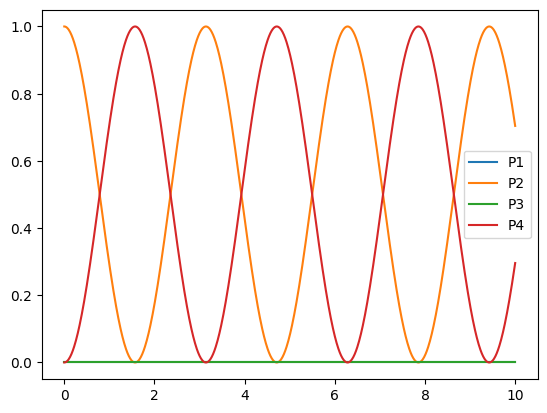

In [21]:
import matplotlib.pyplot as plt
populations = np.array([(torch.abs(state.state_tensor)**2).numpy() for state in states])

fig, ax = plt.subplots()

ax.plot(time, populations[:,0], label = "P1")
ax.plot(time, populations[:,1], label = "P2")
ax.plot(time, populations[:,2], label = "P3")
ax.plot(time, populations[:,3], label = "P4")
ax.legend()

* Simulate dynamics with von-Neumann equations

In [22]:
rho = get_density_matrix(initial_state)
_, states = lindblad_equation(rho, hamiltonian, time, Dt)

P1 = np.array([torch.real(state.matrix[0][0]) for state in states])
P2 = np.array([torch.real(state.matrix[1][1]) for state in states])
P3 = np.array([torch.real(state.matrix[2][2]) for state in states])
P4 = np.array([torch.real(state.matrix[3][3]) for state in states])

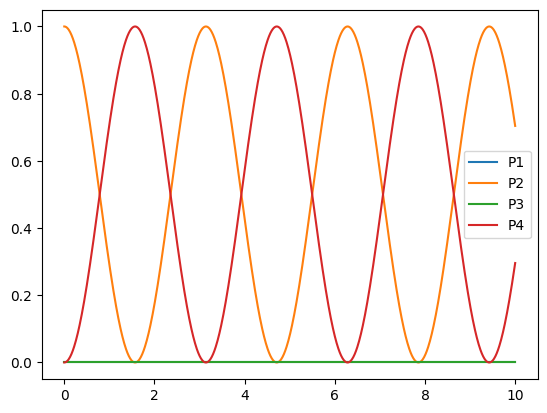

In [23]:
fig, ax = plt.subplots()

ax.plot(time, P1, label = "P1")
ax.plot(time, P2, label = "P2")
ax.plot(time, P3, label = "P3")
ax.plot(time, P4, label = "P4")
ax.legend()

In [24]:
expect_Z_list = expect_val_dm(states, tensor_product_ops(sigmaZ(), sigmaZ()))
expect_Z = np.array(expect_Z_list)

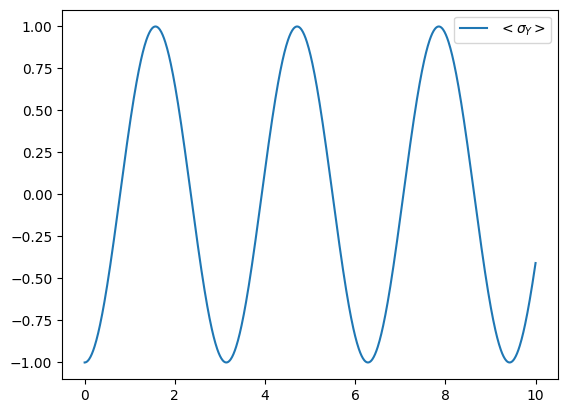

In [26]:
fig, ax = plt.subplots()

ax.plot(time, expect_Z, label = r"$<\sigma_Y>$")
ax.legend()